In [1]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
os.environ["KERAS_BACKEND"] = "torch"
import keras
from datamodules import data_processors
import sys
print(sys.version)

3.13.1 (main, Dec  9 2024, 00:00:00) [GCC 14.2.1 20240912 (Red Hat 14.2.1-3)]


In [2]:
N_archivos = 7
path_rand = map(lambda x: "../input_data/cubic_" + str(x + 1) + ".csv", range(N_archivos))
datos_rand = [pd.read_csv(x) for x in path_rand]
path_to_current_model = "none" #"models/isotropico_act_custom_6.keras" # colocar "none" si quiere entrenar un modelo

In [3]:
(datos_rand[0]["eig_1"][4] - 1)/datos_rand[0]["eig_19"][4]

np.float64(0.08548021299604676)

In [4]:
datos_rand[0].head()

,phi_a,x_K,eta,beta,phi_K,eig_0,eig_1,eig_2,eig_3,eig_4,...,eig_13,eig_14,eig_15,eig_16,eig_17,eig_18,eig_19,Parallelepiped,Cylinder,Ellipsoid
0,0.843666,0.647473,1.577259,1.574131,0.866533,0.552390,2.341186,2.982731,4.346947,4.543615,...,10.255629,10.934964,12.169362,12.639375,13.023291,17.260278,18.912029,1,0,0
1,0.618911,0.218057,1.216162,1.820191,1.350973,0.451902,1.069440,2.198825,3.912317,3.934114,...,11.230938,11.241764,11.468446,14.561622,14.919805,15.338283,15.666733,1,0,0
2,0.076877,0.245986,1.434582,2.036289,1.322259,0.104398,3.832743,4.758215,5.732612,5.807000,...,15.088024,15.429422,16.241738,16.394792,20.165109,25.500514,26.305482,1,0,0
3,1.459619,0.517388,1.481719,1.376496,1.027000,0.202136,2.142934,2.641222,2.779140,3.088002,...,10.969815,12.756643,13.922951,14.045571,15.047647,18.770442,19.392401,1,0,0
4,0.032508,0.949501,1.839938,0.803203,0.319154,0.002714,10.061990,13.963490,14.997477,17.405756,...,56.063736,70.470168,72.668095,76.780522,93.416045,97.561829,106.012724,1,0,0


In [5]:
N_eig = 19
features = ["eta", "beta"] + list(map(lambda x: "x_" + str(x), range(N_eig+1)))
target = ["phi_a", "phi_K"]

In [6]:
datos_post = []
for datos in datos_rand:
    datos_post.append(data_processors.preprocess_data(datos, N_eig, target))
#fin for 
datos_rand = datos_post

In [7]:
datos_rand[0]["x_1"][4]

np.float64(0.08548021299604676)

In [8]:
datos_rand[0].head()

,phi_a,phi_K,eig_0,eta,beta,eig_1,eig_2,eig_3,eig_4,eig_5,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
0,0.537095,0.551652,0.552390,1.577259,1.574131,0.427134,0.784913,0.686167,0.956716,0.970898,...,0.044254,0.003605,0.062714,0.011232,0.035921,0.065271,0.024853,0.020300,0.224037,0.087339
1,0.394011,0.860056,0.451902,1.216162,1.820191,0.935069,0.486369,0.562026,0.994460,0.833391,...,0.036307,0.021216,0.141992,0.012995,0.000691,0.014469,0.197436,0.022863,0.026711,0.020965
2,0.048942,0.841777,0.104398,1.434582,2.036289,0.260910,0.805500,0.830026,0.987190,0.736554,...,0.024378,0.078955,0.079060,0.006715,0.012978,0.030880,0.005818,0.143328,0.202825,0.030601
3,0.929222,0.653809,0.202136,1.481719,1.376496,0.466650,0.811342,0.950374,0.899980,0.743699,...,0.023561,0.006362,0.055864,0.047249,0.092141,0.060143,0.006323,0.051674,0.191972,0.032072
4,0.020696,0.203180,0.002714,1.839938,0.803203,0.099384,0.720593,0.931056,0.861639,0.698142,...,0.060522,0.001708,0.122370,0.014358,0.135893,0.020733,0.038792,0.156920,0.039106,0.079716


In [9]:
X_rand = [datos_rand[x][features] for x in range(N_archivos)]
y_rand = [datos_rand[x][target] for x in range(N_archivos)]

In [10]:
X_train = pd.concat((X_rand[i] for i in range(5)), axis = 0)
y_train = pd.concat((y_rand[i] for i in range(5)), axis = 0)

In [11]:
corr_mat = X_train.select_dtypes(include=['number']).corr()
print(corr_mat)

           eta      beta       x_1       x_2       x_3       x_4       x_5  \
eta   1.000000 -0.000897  0.491277  0.393982  0.196694  0.133444  0.220471   
beta -0.000897  1.000000  0.325628  0.163667  0.404688  0.351768  0.012204   
x_1   0.491277  0.325628  1.000000  0.182083  0.054078  0.052991  0.169650   
x_2   0.393982  0.163667  0.182083  1.000000  0.030579  0.158458  0.165224   
x_3   0.196694  0.404688  0.054078  0.030579  1.000000  0.160123 -0.042368   
x_4   0.133444  0.351768  0.052991  0.158458  0.160123  1.000000 -0.100712   
x_5   0.220471  0.012204  0.169650  0.165224 -0.042368 -0.100712  1.000000   
x_6   0.031186  0.252386  0.053046  0.114739  0.057401  0.178142 -0.040620   
x_7  -0.000648  0.313638  0.062420 -0.004028  0.375232  0.106587 -0.069817   
x_8   0.078018  0.128822  0.215710  0.041753  0.080653  0.074202 -0.031095   
x_9  -0.117432  0.020065 -0.040744  0.070762 -0.040750 -0.012536  0.014343   
x_10 -0.182727  0.037804 -0.173975 -0.031642 -0.066953 -0.033298

Text(0.5, 1.0, 'Correlation Matrix')

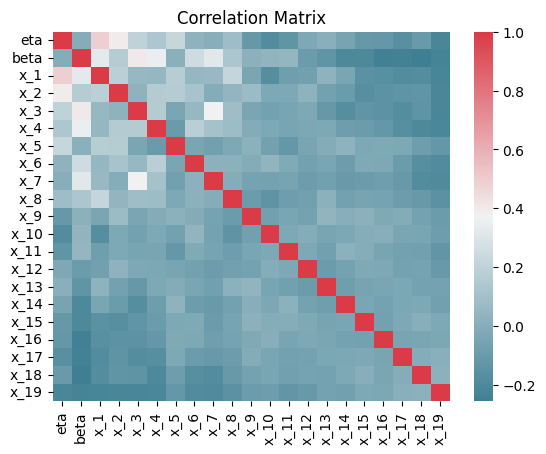

In [12]:
sns.heatmap(corr_mat, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation Matrix")

In [13]:
torch.cuda.get_device_properties(torch.device("cuda"))

_CudaDeviceProperties(name='AMD Radeon RX 6600M', major=10, minor=3, gcnArchName='gfx1030', total_memory=8176MB, multi_processor_count=14, uuid=58580000-0000-0000-0000-000000000000, L2_cache_size=2MB)

In [14]:
def crear_modelo_de_regresion(lr_var, n_input_data, def_act = 'relu'):    
    modelo = keras.models.Sequential()
    modelo.add(keras.layers.Dense(128, activation = def_act, input_shape = (n_input_data,)))
    modelo.add(keras.layers.Dense(512, activation = def_act))
    modelo.add(keras.layers.Dense(752, activation = def_act))
    modelo.add(keras.layers.Dense(1245, activation = def_act))
    modelo.add(keras.layers.Dense(4872, activation = def_act))
    modelo.add(keras.layers.Dense(3304, activation = def_act))
    modelo.add(keras.layers.Dense(1974, activation = def_act))
    modelo.add(keras.layers.Dense(1240, activation = def_act))
    modelo.add(keras.layers.Dense(512, activation = def_act))
    modelo.add(keras.layers.Dense(256, activation = def_act))
    modelo.add(keras.layers.Dense(32, activation = def_act))
    modelo.add(keras.layers.Dense(2, activation = 'hard_sigmoid'))
    modelo.compile(optimizer = keras.optimizers.Adam(learning_rate = lr_var), loss = 'mse', metrics = ['mae']) #RMSprop
    return modelo

In [15]:
k = 4 #4 sets de validación
n_muestras_val = len(X_train) // k
epocas = 100
all_history = []

In [16]:
if path_to_current_model == "none":
    modelo = crear_modelo_de_regresion(0.0005, len(features))
    history = modelo.fit(X_train, y_train, epochs = epocas, batch_size=64, 
                            validation_data = (X_rand[5], y_rand[5]))
                            #24
else:
    modelo = keras.models.load_model(path_to_current_model)
#fin if 

/home/cubos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/home/cubos/.local/lib/python3.13/site-packages/keras/src/backend/torch/numpy.py:114: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:328.)
  return cast(torch.matmul(x1, x2), result_dtype)


3906/3906 ━━━━━━━━━━━━━━━━━━━━ 131s 33ms/step - loss: 0.0564 - mae: 0.1952 - val_loss: 0.0348 - val_mae: 0.1417
Epoch 2/100
3906/3906 ━━━━━━━━━━━━━━━━━━━━ 130s 33ms/step - loss: 0.0320 - mae: 0.1345 - val_loss: 0.0266 - val_mae: 0.1192
Epoch 3/100
3906/3906 ━━━━━━━━━━━━━━━━━━━━ 130s 33ms/step - loss: 0.0256 - mae: 0.1152 - val_loss: 0.0224 - val_mae: 0.1052
Epoch 4/100
3906/3906 ━━━━━━━━━━━━━━━━━━━━ 130s 33ms/step - loss: 0.0223 - mae: 0.1048 - val_loss: 0.0197 - val_mae: 0.0951
Epoch 5/100
3906/3906 ━━━━━━━━━━━━━━━━━━━━ 130s 33ms/step - loss: 0.0200 - mae: 0.0970 - val_loss: 0.0194 - val_mae: 0.0941
Epoch 6/100
3906/3906 ━━━━━━━━━━━━━━━━━━━━ 130s 33ms/step - loss: 0.0186 - mae: 0.0920 - val_loss: 0.0177 - val_mae: 0.0890
Epoch 7/100
3906/3906 ━━━━━━━━━━━━━━━━━━━━ 130s 33ms/step - loss: 0.0176 - mae: 0.0885 - val_loss: 0.0177 - val_mae: 0.0891
Epoch 8/100
3906/3906 ━━━━━━━━━━━━━━━━━━━━ 131s 33ms/step - loss: 0.0163 - mae: 0.0840 - val_loss: 0.0152 - val_mae: 0.0794
Epoch 9/100
3906/390

In [17]:
mets_train = data_processors.get_metrics(X_train, y_train, modelo)
mets_val = data_processors.get_metrics(X_rand[5], y_rand[5], modelo)
mets_rand1 = data_processors.get_metrics(X_rand[6], y_rand[6], modelo)

   1/7812 ━━━━━━━━━━━━━━━━━━━━ 1:21 10ms/step

7812/7812 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step


In [18]:
print("Train: ", mets_train)
print("Val: ", mets_val)
print("Test: ", mets_rand1)

Train:  {'R2': 0.9317399263381958, 'RMSE': 0.0594976581633091, 'MAE': 0.03581856191158295, 'SDAE': np.float64(0.23058875514297608)}
Val:  {'R2': 0.8571345806121826, 'RMSE': 0.08553483337163925, 'MAE': 0.04898706451058388, 'SDAE': np.float64(0.23031351594503005)}
Test:  {'R2': 0.8588114976882935, 'RMSE': 0.08519294112920761, 'MAE': 0.04897134006023407, 'SDAE': np.float64(0.23090860848053374)}


In [19]:
if path_to_current_model == "none":
    modelo.save("models/cubico_L2.keras")
#fin if 

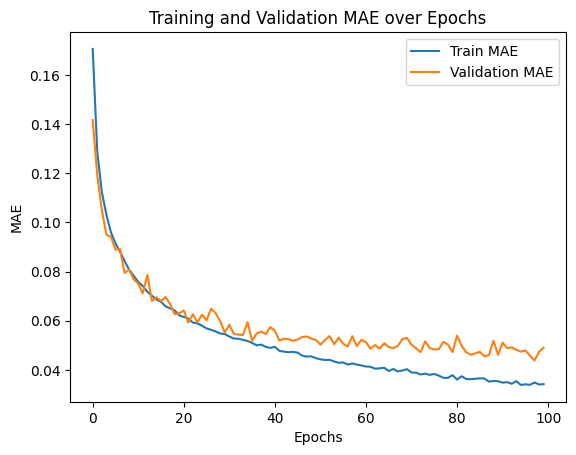

In [20]:
if path_to_current_model == "none":
    train_mae = history.history["mae"]
    val_mae = history.history["val_mae"]
    plt.figure()
    plt.plot(train_mae, label='Train MAE')
    plt.plot(val_mae, label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE over Epochs')
    plt.legend()

In [21]:
if path_to_current_model == "none":
    import json
    with open('models/cubic_history_L2.json', 'w') as f:
        json.dump(history.history, f)